In [1]:
import os

import pandas as pd
from nixtla import NixtlaClient

# Anomaly detection

## Import packages

Import required libraries for data manipulation and Nixtla client initialization.

In [2]:
NIXTLA_API_KEY = os.environ["NIXTLA_API_KEY"]
nixtla_client = NixtlaClient(api_key=NIXTLA_API_KEY)

Initialize Nixtla client with API key from environment variables.

## Load dataset

Now, let's load the dataset for this tutorial.

In [3]:
# Read the dataset
wikipedia = pd.read_csv("https://datasets-nixtla.s3.amazonaws.com/peyton-manning.csv", parse_dates=["ds"])
wikipedia.head(10)

,unique_id,ds,y
0,0,2007-12-10,9.590761
1,0,2007-12-11,8.519590
2,0,2007-12-12,8.183677
3,0,2007-12-13,8.072467
4,0,2007-12-14,7.893572
5,0,2007-12-15,7.783641
6,0,2007-12-16,8.414052
7,0,2007-12-17,8.829226
8,0,2007-12-18,8.382518
9,0,2007-12-19,8.069655


Load the Peyton Manning Wikipedia page views dataset and display first 10 rows.

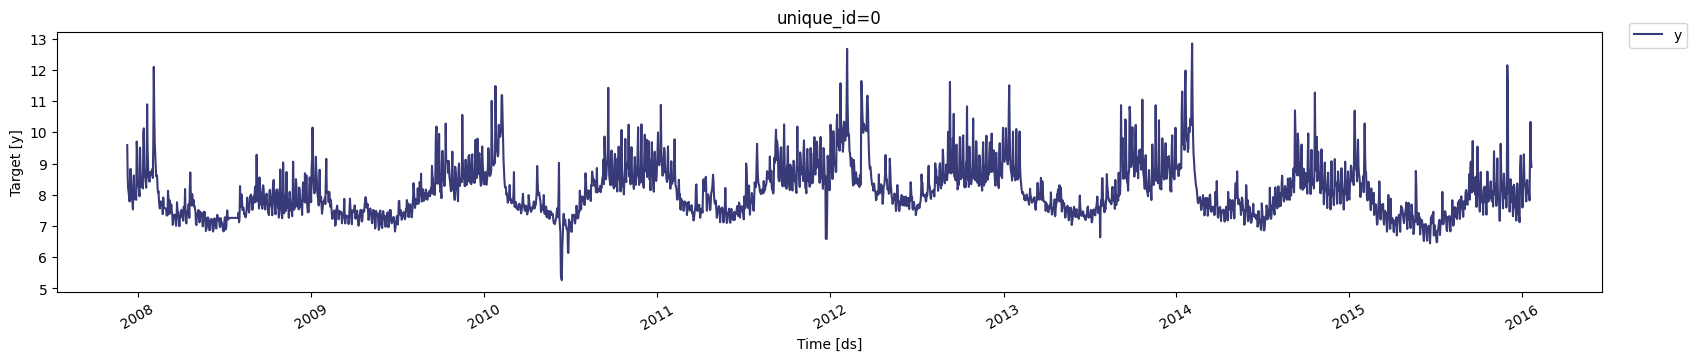

In [4]:
wikipedia_plot = nixtla_client.plot(wikipedia)
wikipedia_plot

Plot the time series data to visualize the patterns.

In [5]:
anomalies_df = nixtla_client.detect_anomalies(
    wikipedia,
    freq="D",
    model="timegpt-1",
)
anomalies_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...


,unique_id,ds,y,TimeGPT,TimeGPT-hi-99,TimeGPT-lo-99,anomaly
0,0,2008-01-10,8.281724,8.224190,9.503590,6.944790,False
1,0,2008-01-11,8.292799,8.151552,9.430952,6.872153,False
2,0,2008-01-12,8.199189,8.127275,9.406675,6.847876,False
3,0,2008-01-13,9.996522,8.917264,10.196664,7.637865,False
4,0,2008-01-14,10.127071,9.002328,10.281728,7.722929,False


## Anomaly detection

Detect anomalies in the time series using TimeGPT model with default settings.

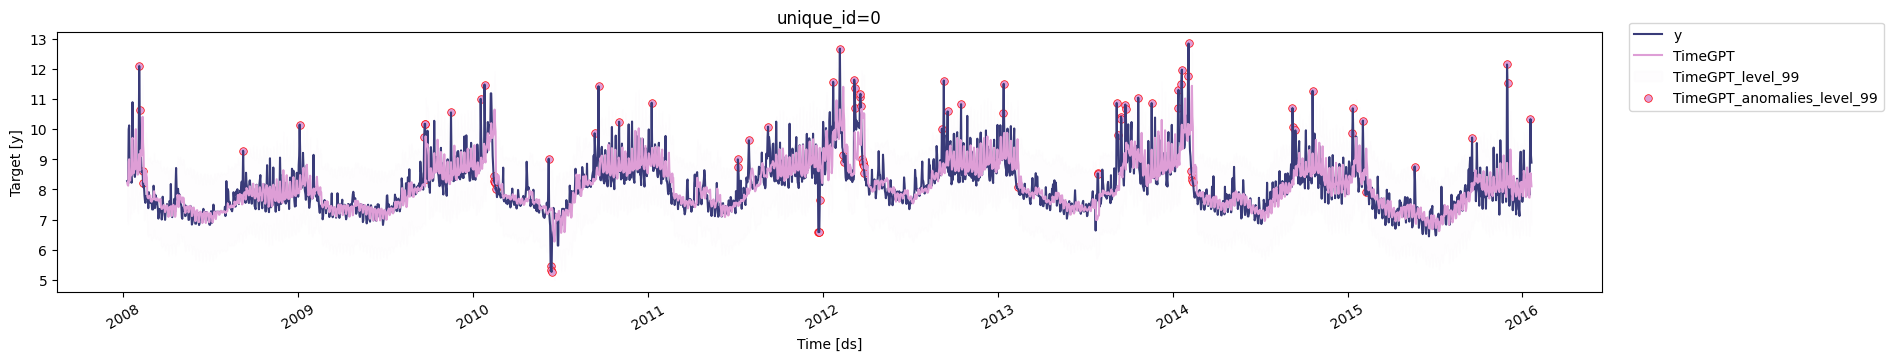

In [6]:
anomaly_plot = nixtla_client.plot(wikipedia, anomalies_df)
anomaly_plot

Visualize the detected anomalies on the time series plot.

In [7]:
anomalies_df_exogenous = nixtla_client.detect_anomalies(
    wikipedia,
    freq="D",
    date_features=["month", "year"],
    date_features_to_one_hot=True,
    model="timegpt-1",
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using the following exogenous features: ['month_1.0', 'month_2.0', 'month_3.0', 'month_4.0', 'month_5.0', 'month_6.0', 'month_7.0', 'month_8.0', 'month_9.0', 'month_10.0', 'month_11.0', 'month_12.0', 'year_2007.0', 'year_2008.0', 'year_2009.0', 'year_2010.0', 'year_2011.0', 'year_2012.0', 'year_2013.0', 'year_2014.0', 'year_2015.0', 'year_2016.0']
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...


## Anomaly detection with exogenous features

Detect anomalies using TimeGPT with additional date-based features (month and year).

<Axes: ylabel='features'>

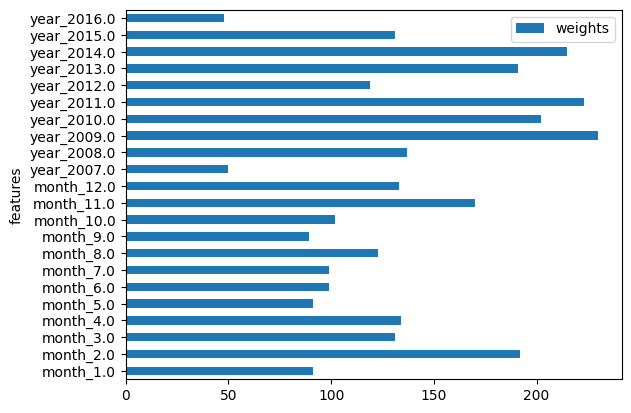

In [8]:
feature_plot = nixtla_client.weights_x.plot.barh(
    x="features",
    y="weights"
)

feature_plot

Plot the feature importance weights to understand which features contribute most to anomaly detection.

In [9]:
# Without exogenous features
print("Number of anomalies without exogenous features:", anomalies_df.anomaly.sum())

# With exogenous features
print("Number of anomalies with exogenous features:", anomalies_df_exogenous.anomaly.sum())

Number of anomalies without exogenous features: 89
Number of anomalies with exogenous features: 92


Compare the number of anomalies detected with and without exogenous features.

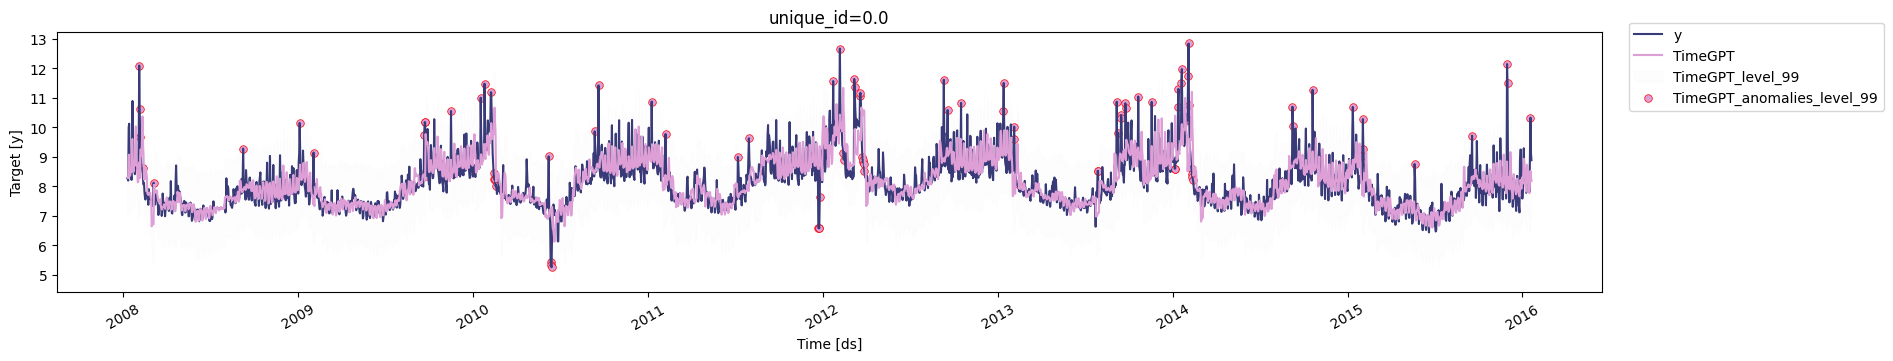

In [10]:
anomalies_exogenous_plot = nixtla_client.plot(wikipedia, anomalies_df_exogenous)
anomalies_exogenous_plot

Visualize the anomalies detected using the model with exogenous features.

In [11]:
anomalies_df_70 = nixtla_client.detect_anomalies(wikipedia, freq="D", level=70)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...


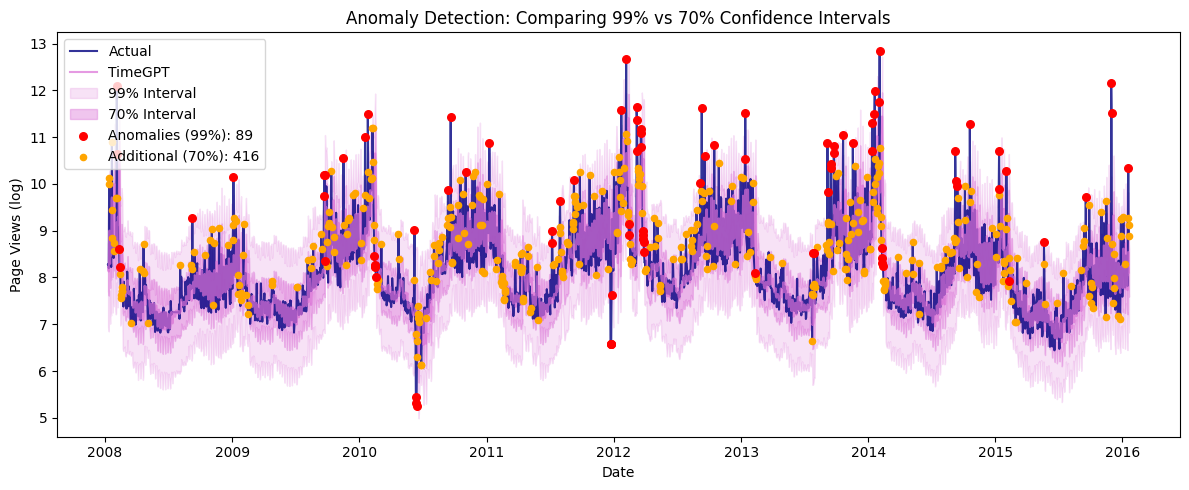

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 5))

# Plot original data
ax.plot(anomalies_df["ds"], anomalies_df["y"], color="navy", alpha=0.8, label="Actual")

# Plot TimeGPT forecast
ax.plot(anomalies_df["ds"], anomalies_df["TimeGPT"], color="orchid", alpha=0.7, label="TimeGPT")

# Fill 99% confidence interval
ax.fill_between(
    anomalies_df["ds"],
    anomalies_df["TimeGPT-lo-99"],
    anomalies_df["TimeGPT-hi-99"],
    alpha=0.2,
    color="orchid",
    label="99% Interval"
)

# Fill 70% confidence interval
ax.fill_between(
    anomalies_df_70["ds"],
    anomalies_df_70["TimeGPT-lo-70"],
    anomalies_df_70["TimeGPT-hi-70"],
    alpha=0.4,
    color="orchid",
    label="70% Interval"
)

# Highlight anomalies from 99% interval
anomalies_99 = anomalies_df[anomalies_df["anomaly"] == True]
ax.scatter(anomalies_99["ds"], anomalies_99["y"], color="red", s=30, zorder=5, label=f"Anomalies (99%): {len(anomalies_99)}")

# Highlight anomalies from 70% interval (only those not in 99%)
anomalies_70_only = anomalies_df_70[(anomalies_df_70["anomaly"] == True) & (~anomalies_df_70["ds"].isin(anomalies_99["ds"]))]
ax.scatter(anomalies_70_only["ds"], anomalies_70_only["y"], color="orange", s=20, zorder=4, label=f"Additional (70%): {len(anomalies_70_only)}")

ax.set_xlabel("Date")
ax.set_ylabel("Page Views (log)")
ax.set_title("Anomaly Detection: Comparing 99% vs 70% Confidence Intervals")
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

Visualize both confidence intervals together. The darker shaded region shows the 70% interval (narrower), while the lighter region shows the 99% interval (wider). Red points are anomalies detected by the 99% threshold, and orange points are additional anomalies detected only by the stricter 70% threshold.

## Modifying the confidence intervals

Detect anomalies using a lower confidence interval (70%) to see how it affects the results.

In [12]:
# Print and compare anomaly counts
print("Number of anomalies with 99% confidence interval:", anomalies_df.anomaly.sum())
print("Number of anomalies with 70% confidence interval:", anomalies_df_70.anomaly.sum())

Number of anomalies with 99% confidence interval: 89
Number of anomalies with 70% confidence interval: 505


Compare the number of anomalies detected with different confidence intervals (99% vs 70%).

In [ ]:
anomalies_70_plot = nixtla_client.plot(wikipedia, anomalies_df_70)
anomalies_70_plot

Visualize the anomalies detected using the 70% confidence interval.